In [5]:
import PyPlot
const plt = PyPlot
plt.svg(true);

In [105]:
using SparseArrays
using LinearAlgebra
using Printf

In [12]:
using Random
Random.seed!(1234);

# Simulasi dekomposisi spinodal dari alloy biner

Persamaan Cahn-Hilliard: 

$$
\frac{\partial c_{i}}{\partial t} = \nabla M_{ij} \nabla \frac{\delta F}{\delta c_{j}(r,t)}
$$

dengan

$$
\frac{\partial \eta_{p}}{\partial t} = -L_{pq} \frac{\delta F}{\delta \eta_{q}(r,t)}
$$

Pada persamaan tersebut $r$ adalah posisi,  $t$ adalah waktu, $c_{1}, c_{2}, \ldots, c_{n}$ adalah variabel medan terkonservasi, $\eta_{1}, \eta_{2}, \dots, \eta_{m}$ adalah variabel medan tidak terkonservasi, $M_{ij}$ adalah difusivitas spesies, $L_{pq}$: mobilitas variable medan tidak terkonservasi dan $F$ adalah energi bebas dari sistem

Kita akan mengambil $F$ berbentuk sebagai berikut: 

$$
\int_{V} \left[ f(c) + \frac{1}{2}\kappa \left( \nabla^2 \right) \right]\,\mathrm{d}v
$$

di mana $\kappa$ adalah koefisien energi gradient dan $f(c)$ adalah energi kimia/bulk yang dapat ditulis sebagai

$$
f(c) = Ac^2(1-c)^2
$$

Ekspresi untuk energi kimia yang lain adalah

$$
f(c) = \frac{1}{4} A (1-c^2)^2
$$

dan

$$
f(c) = 4A \left( -\frac{1}{2}c^2 + \frac{1}{4}c^4 \right)
$$

### Bentuk Energi kimia #1

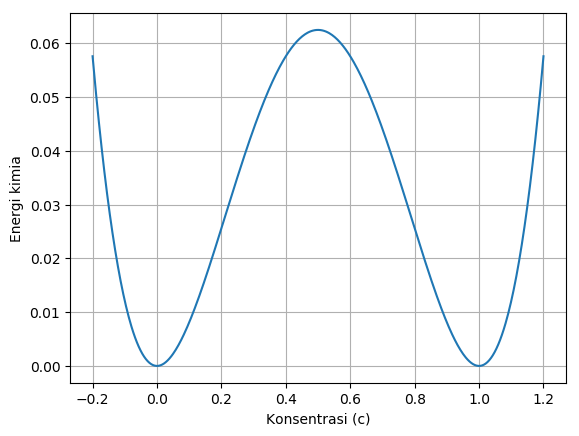

In [9]:
function chemical_energy(A,c)
    return A * c^2 * (1 - c)^2
end

NptsPlot = 500
c = range(-0.2, stop=1.2, length=NptsPlot)
f = chemical_energy.(1.0, c)

plt.clf()
plt.plot(c, f)
plt.xlabel("Konsentrasi (c)")
plt.ylabel("Energi kimia")
plt.grid(true)

### Bentuk energi kimia #2

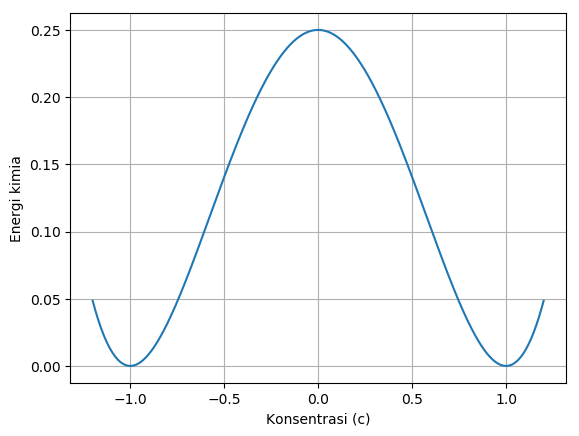

In [10]:
function chemical_energy_v2(A,c)
    return 0.25*A*(1-c^2)^2
end

NptsPlot = 500
c = range(-1.2, stop=1.2, length=NptsPlot)
f = chemical_energy_v2.(1.0, c)

plt.clf()
plt.plot(c, f)
plt.xlabel("Konsentrasi (c)")
plt.ylabel("Energi kimia")
plt.grid(true)

### Bentuk energi kimia #3

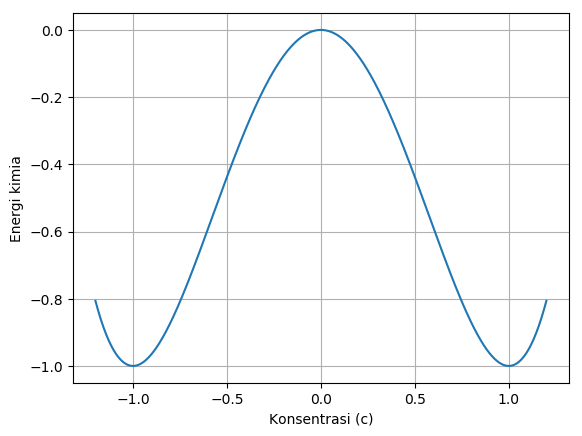

In [8]:
function free_energy_v3(A,c)
    return 4*A*( -0.5*c^2 + 0.25*c^4 )
end

NptsPlot = 500
c = range(-1.2, stop=1.2, length=NptsPlot)
f = free_energy_v3.(1.0, c)

plt.clf()
plt.plot(c, f)
plt.xlabel("Konsentrasi (c)")
plt.ylabel("Energi kimia")
plt.grid(true)

## Diskritisasi

Bentuk terdiskritisasi dari persamaan Cahn-Hilliard (menggunakan skema forward Euler):

$$
\frac{c^{n+1}_{ij} - c^{n}_{ij}}{\Delta t} =
\nabla^2 M \left( \frac{\delta F_{ij}}{\delta c} \right)^n
$$

Turunan fungsional dari energi bebas adalah

$$
\left( \frac{\delta F_{ij}}{\delta c} \right)^n = \mu(c^{n}_{ij}) - \kappa \nabla^2 c^{n}_{ij}
$$

$\mu(c^{n}_{ij})$ adalah turunan fungsional dari energi kimia:

$$
\mu(c^{n}_{ij}) = A \left(
2c^{n}_{ij} (1 - c^{n}_{ij})^2 + 2(c^{n}_{ij})^2 (1 - c^{n}_{ij})
\right)
$$

Untuk memonitor variasi dari energi bebas selama evolusi, didefinisikan fungsional energi diskrit:

$$
F_{D} = \sum_{i}^{N_{x}} \sum_{j}^{N_{y}} f(c^{n}_{ij}) +
\frac{\kappa}{2} \left( 
\sum_{i}^{N_{x}-1} \sum_{j}^{N_{y}-1} \left( c^{n}_{i+1,j} - c^{n}_{ij} \right)^2 +
\sum_{i}^{N_{x}-1} \sum_{j}^{N_{y}-1} \left( c^{n}_{i,j+1} - c^{n}_{ij} \right)^2
\right)
$$

# Calculation

In [65]:
function initial_concentration( Nx::Int64, Ny::Int64, c0::Float64 )
    noise = 0.02
    Npoints = Nx*Ny
    conc = zeros(Npoints)
    ip = 0
    xy2ip = zeros(Int64,Nx,Ny)
    ip2xy = zeros(2,Npoints)
    for j = 1:Ny
        for i = 1:Nx
            ip = ip + 1
            conc[ip] = c0 + noise*(0.5 - rand())
            ip2xy[1,ip] = i
            ip2xy[2,ip] = j
            xy2ip[i,j] = ip
        end
    end
    return conc, ip2xy, xy2ip
end

initial_concentration (generic function with 1 method)

In [66]:
c0 = 0.4
Nx = 64
Ny = 64
conc, ip2xy, xy2ip = initial_concentration(Nx,Ny,c0);

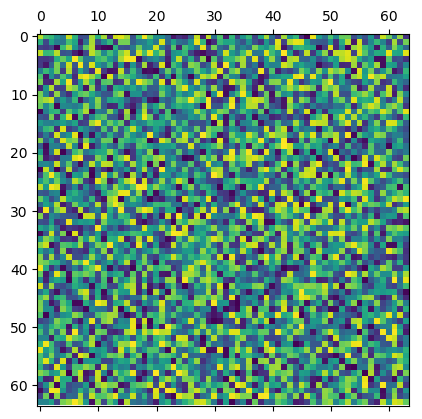

In [67]:
plt.clf()
plt.matshow(reshape(conc,(Nx,Ny)));

In [28]:
function build_d2_dx2_matrix(N::Int64, h::Float64)
    mat = zeros(N,N)
    for i = 1:N
        mat[i,i] = -2.0/h^2
        if i != N
            mat[i,i+1] = 1/h^2
            mat[i+1,i] = mat[i,i+1]
        end
    end
    mat[1,N] = 1/h^2
    mat[N,1] = 1/h^2
    return mat
end

build_d2_dx2_matrix (generic function with 2 methods)

In [24]:
dx = 1.0
dy = 1.0;

In [29]:
D2x = build_d2_dx2_matrix(5,dx)

5×5 Array{Float64,2}:
 -2.0   1.0   0.0   0.0   1.0
  1.0  -2.0   1.0   0.0   0.0
  0.0   1.0  -2.0   1.0   0.0
  0.0   0.0   1.0  -2.0   1.0
  1.0   0.0   0.0   1.0  -2.0

In [32]:
D2x = sparse(D2x)

5×5 SparseMatrixCSC{Float64,Int64} with 15 stored entries:
  [1, 1]  =  -2.0
  [2, 1]  =  1.0
  [5, 1]  =  1.0
  [1, 2]  =  1.0
  [2, 2]  =  -2.0
  [3, 2]  =  1.0
  [2, 3]  =  1.0
  [3, 3]  =  -2.0
  [4, 3]  =  1.0
  [3, 4]  =  1.0
  [4, 4]  =  -2.0
  [5, 4]  =  1.0
  [1, 5]  =  1.0
  [4, 5]  =  1.0
  [5, 5]  =  -2.0

In [39]:
kron(sparse(Matrix(1.0I, 5, 5)), D2x)

25×25 SparseMatrixCSC{Float64,Int64} with 75 stored entries:
  [1 ,  1]  =  -2.0
  [2 ,  1]  =  1.0
  [5 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [2 ,  2]  =  -2.0
  [3 ,  2]  =  1.0
  [2 ,  3]  =  1.0
  [3 ,  3]  =  -2.0
  [4 ,  3]  =  1.0
  [3 ,  4]  =  1.0
  [4 ,  4]  =  -2.0
  [5 ,  4]  =  1.0
  ⋮
  [21, 22]  =  1.0
  [22, 22]  =  -2.0
  [23, 22]  =  1.0
  [22, 23]  =  1.0
  [23, 23]  =  -2.0
  [24, 23]  =  1.0
  [23, 24]  =  1.0
  [24, 24]  =  -2.0
  [25, 24]  =  1.0
  [21, 25]  =  1.0
  [24, 25]  =  1.0
  [25, 25]  =  -2.0

In [41]:
function calc_nabla2(Nx,Ny,dx,dy)
    D2x = sparse( build_d2_dx2_matrix(Nx,dx) )
    D2y = sparse( build_d2_dx2_matrix(Ny,dy) )
    Ixx = sparse( Matrix(1.0I, Nx, Nx) )
    Iyy = sparse( Matrix(1.0I, Ny, Ny) )
    nabla2 = kron(D2x,Iyy) + kron(Ixx,D2y)
end

calc_nabla2 (generic function with 2 methods)

In [43]:
nabla2 = calc_nabla2( 5, 5, 1.0, 1.0 )

25×25 SparseMatrixCSC{Float64,Int64} with 125 stored entries:
  [1 ,  1]  =  -4.0
  [2 ,  1]  =  1.0
  [5 ,  1]  =  1.0
  [6 ,  1]  =  1.0
  [21,  1]  =  1.0
  [1 ,  2]  =  1.0
  [2 ,  2]  =  -4.0
  [3 ,  2]  =  1.0
  [7 ,  2]  =  1.0
  [22,  2]  =  1.0
  [2 ,  3]  =  1.0
  [3 ,  3]  =  -4.0
  ⋮
  [23, 23]  =  -4.0
  [24, 23]  =  1.0
  [4 , 24]  =  1.0
  [19, 24]  =  1.0
  [23, 24]  =  1.0
  [24, 24]  =  -4.0
  [25, 24]  =  1.0
  [5 , 25]  =  1.0
  [20, 25]  =  1.0
  [21, 25]  =  1.0
  [24, 25]  =  1.0
  [25, 25]  =  -4.0

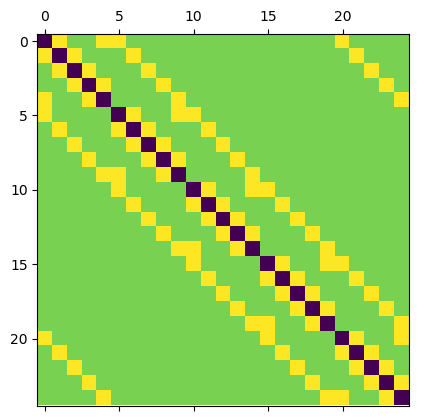

PyObject <matplotlib.image.AxesImage object at 0x7f1920fdc748>

In [44]:
plt.clf()
plt.matshow(Array(nabla2))

In [46]:
nabla2 = calc_nabla2(Nx,Ny,dx,dy);

In [69]:
d2conc = nabla2*conc;

In [86]:
function calc_deriv_chemical_energy( A, c )
    Npoints = length(c)
    mu = zeros(Npoints)
    mu = A * ( 2.0 * c .* ( 1.0 .- c ).^2 - 2.0 * c.^2 .* ( 1.0 .- c )) 
    return mu
end

calc_deriv_chemical_energy (generic function with 1 method)

In [87]:
mu = calc_deriv_chemical_energy(1.0, conc);

In [83]:
kappa = 0.5;

0.5

In [88]:
dFdc = mu - nabla2*conc;

In [93]:
dt = 0.01;
mobility = 1.0;

In [94]:
conc = conc + dt*mobility*nabla2*dFdc;

## Simulasi

In [ ]:
Nx = 64
Ny = 64
dx = 1.0
dy = 1.0
dt = 0.01
c0 = 0.4
kappa = 0.5
dt = 0.01
mobility = 1.0
A = 1.0

In [103]:
nstep = 10000;
nprint = 50;

In [98]:
nabla2 = calc_nabla2(Nx,Ny,dx,dy);

In [99]:
mu = zeros(Nx*Nx)
dFdc = zeros(Nx*Ny);

In [113]:
function calc_energy( c, xy2ip, kappa )
    E_D = 0.0
    for j = 1:Ny-1
    for i = 1:Nx-1 
        jp1 = j + 1
        ip = xy2ip[i,j]
        ipx = xy2ip[i+1,j]
        ipy = xy2ip[i,j+1]
        E_D = E_D + c[ip]^2 * ( 1.0 - c[ip] )^2 +
            0.5*kappa*( ( c[ipx] - c[ip] )^2 + ( c[ipy] - c[ip] )^2 )
    end
    end
    return E_D
end

calc_energy (generic function with 1 method)

In [114]:
calc_energy(conc, xy2ip, kappa)

114.20907314178706

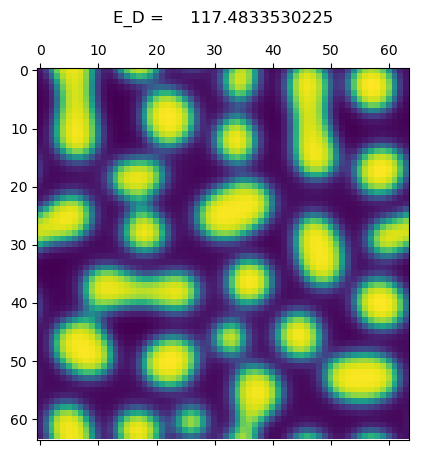

In [115]:
conc, ip2xy, xy2ip = initial_concentration(Nx,Ny,c0);
for n = 1:nstep
    mu = calc_deriv_chemical_energy(A, conc)
    dFdc = mu - nabla2*conc;
    conc = conc + dt*mobility*nabla2*dFdc
    if (n % nprint == 0) || n == 1
        ene = calc_energy(conc, xy2ip, kappa)
        plt.clf()
        plt.matshow(reshape(conc,(Nx,Nx)));
        title = @sprintf("E_D = %18.10f\n", ene)
        plt.title(title)
        filename = @sprintf("TEMP_t_%08d.png", n)
        plt.savefig(filename,dpi=200)
    end
end

## Mungkin akan dibuang

In [ ]:
function initial_concentration_old( Nx::Int64, Ny::Int64, c0::Float64 )
    noise = 0.02
    conc = zeros(Nx,Ny)
    for j = 1:Ny
        for i = 1:Nx
            conc[i,j] = c0 + noise*(0.5 - rand())
        end
    end
    return conc
end

In [59]:
A = rand(3,4)
lin_idx = LinearIndices(A)

3×4 LinearIndices{2,Tuple{Base.OneTo{Int64},Base.OneTo{Int64}}}:
 1  4  7  10
 2  5  8  11
 3  6  9  12

In [60]:
B = rand(12,12);

In [62]:
B*A[lin_idx]

DimensionMismatch: DimensionMismatch("A has dimensions (12,12) but B has dimensions (3,4)")